# DATA MODELING - 2

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import os
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Paths
project_root = Path(os.getcwd()).parents[0]
data_folder = project_root / 'data' / 'data_accidents'
grid_weather_dir = data_folder / "grid_weather"
os.makedirs(grid_weather_dir, exist_ok=True)

In [5]:
# You'll need these later
try:
    import openmeteo_requests
    import requests_cache
    from retry_requests import retry
except ImportError:
    !pip install openmeteo-requests requests-cache retry-requests

# Setup Open-Meteo client (from your original code)
cache_session = requests_cache.CachedSession('.cache', expire_after=86400)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

In [8]:
### STEP 1: Check FARS columns across years (corrected for LONGITUD)
years_to_check = ["1980", "1990", "2000", "2010", "2020"]
for year in years_to_check:
    folder = data_folder / year
    acc_file = folder / 'accident.csv'
    if acc_file.exists():
        try:
            df = pd.read_csv(acc_file, nrows=1, encoding='utf-8')
        except:
            df = pd.read_csv(acc_file, nrows=1, encoding='latin1')
        print(f"\n{year} columns:")
        print(f"  Has LAT/LON: {'LATITUDE' in df.columns and 'LONGITUD' in df.columns}")
        print(f"  Has YEAR/MONTH/DAY: {all(c in df.columns for c in ['YEAR', 'MONTH', 'DAY'])}")
        print(f"  Has DATE: {'DATE' in df.columns}")
        if 'WEATHER' in df.columns:
            print(f"  Has WEATHER condition: True")


1980 columns:
  Has LAT/LON: False
  Has YEAR/MONTH/DAY: True
  Has DATE: False
  Has WEATHER condition: True

1990 columns:
  Has LAT/LON: False
  Has YEAR/MONTH/DAY: True
  Has DATE: False
  Has WEATHER condition: True

2000 columns:
  Has LAT/LON: True
  Has YEAR/MONTH/DAY: True
  Has DATE: False
  Has WEATHER condition: True

2010 columns:
  Has LAT/LON: True
  Has YEAR/MONTH/DAY: True
  Has DATE: False
  Has WEATHER condition: True

2020 columns:
  Has LAT/LON: True
  Has YEAR/MONTH/DAY: True
  Has DATE: False
  Has WEATHER condition: True


In [9]:
STATE_CENTROIDS = {
    1: (32.3182, -86.9023),   # Alabama
    2: (64.2008, -149.4853),  # Alaska
    4: (34.0489, -111.0937),  # Arizona
    5: (34.7996, -92.1849),   # Arkansas
    6: (37.2719, -119.2702),  # California
    8: (39.5501, -105.7821),  # Colorado
    9: (41.6032, -73.0877),   # Connecticut
    10: (39.1398, -75.5052),  # Delaware
    11: (38.8974, -77.0268),  # District of Columbia
    12: (27.6648, -81.5158),  # Florida
    13: (32.1656, -82.9001),  # Georgia
    15: (19.8968, -155.5828), # Hawaii
    16: (44.0682, -114.7420), # Idaho
    17: (39.7837, -89.6501),  # Illinois
    18: (39.7910, -86.1490),  # Indiana
    19: (41.8780, -93.0977),  # Iowa
    20: (38.5266, -96.7265),  # Kansas
    21: (37.8393, -85.7170),  # Kentucky
    22: (31.2448, -92.1450),  # Louisiana
    23: (45.2538, -69.4455),  # Maine
    24: (39.0458, -76.6413),  # Maryland
    25: (42.4072, -71.3824),  # Massachusetts
    26: (43.3266, -84.5361),  # Michigan
    27: (45.6945, -93.9002),  # Minnesota
    28: (32.3547, -90.0602),  # Mississippi
    29: (38.5443, -92.2884),  # Missouri
    30: (46.9653, -110.0845), # Montana
    31: (41.4925, -99.9018),  # Nebraska
    32: (38.8026, -116.4194), # Nevada
    33: (43.1939, -71.5724),  # New Hampshire
    34: (40.2237, -74.7647),  # New Jersey
    35: (34.5199, -106.0186), # New Mexico
    36: (42.7512, -75.7634),  # New York
    37: (35.7718, -80.0211),  # North Carolina
    38: (47.5515, -100.4659), # North Dakota
    39: (40.4173, -82.9071),  # Ohio
    40: (35.0078, -97.0929),  # Oklahoma
    41: (44.0009, -120.5542), # Oregon
    42: (40.5908, -77.2098),  # Pennsylvania
    44: (41.5801, -71.4774),  # Rhode Island
    45: (33.8361, -81.1637),  # South Carolina
    46: (44.5000, -100.0000), # South Dakota
    47: (35.5175, -86.5804),  # Tennessee
    48: (31.9686, -99.9018),  # Texas
    49: (40.1500, -111.8625), # Utah
    50: (44.5588, -72.5778),  # Vermont
    51: (37.4316, -78.6569),  # Virginia
    53: (47.7511, -120.7401), # Washington
    54: (38.5976, -80.4549),  # West Virginia
    55: (44.5000, -89.5000),  # Wisconsin
    56: (43.0000, -107.5000)  # Wyoming
}

This step constructs a unified **daily fatal crash dataset** that combines two spatial strategies based on FARS data availability:

- **1975–1999**: FARS does **not** include precise crash coordinates.
  → We assign each crash to its **state centroid** (using predefined latitude/longitude from `STATE_CENTROIDS`).

- **2000–2023**: FARS includes **actual crash coordinates** (`LATITUDE` and `LONGITUD`).
  → We use these exact locations (after filtering for valid U.S. coordinates: 24°N–50°N, 125°W–66°W).

#### Key Processing Steps:
1. **Parse date** from `YEAR`, `MONTH`, and `DAY` columns (excluding invalid dates like `DAY = 0`).
2. **Normalize longitude column name** from `LONGITUD` → `LONGITUDE` (FARS uses truncated SAS names).
3. **Filter coordinates** to remove zeros, nulls, and non-CONUS locations.
4. **Tag each record** with `location_type` (`'crash_exact'` or `'state_centroid'`) for transparency.
5. **Save the final dataset** as `fars_daily_hybrid_coords.csv`.

This hybrid approach ensures **maximal spatial accuracy** where possible while preserving **full historical coverage**, forming the foundation for high-resolution weather–crash analysis at the daily level.

In [10]:
### STEP 2: Build hybrid daily crash dataset (state-level before 2000, crash-level after)
def parse_hybrid_daily():
    all_crashes = []

    for year_folder in tqdm(sorted(data_folder.iterdir()), desc="Parsing FARS"):
        if not year_folder.is_dir():
            continue

        acc_file = year_folder / 'accident.csv'
        if not acc_file.exists():
            continue

        year = int(year_folder.name)

        try:
            df = pd.read_csv(acc_file, low_memory=False, encoding='utf-8')
        except:
            df = pd.read_csv(acc_file, low_memory=False, encoding='latin1')

        # Parse date
        if all(col in df.columns for col in ['YEAR', 'MONTH', 'DAY']):
            df = df[(df['DAY'] > 0) & (df['MONTH'] > 0)]
            df['date'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']], errors='coerce')
        else:
            continue

        if 'STATE' not in df.columns:
            continue

        if year >= 2000 and 'LATITUDE' in df.columns and 'LONGITUD' in df.columns:
            # 📍 Use actual crash coordinates (2000–2023)
            df = df.rename(columns={'LONGITUD': 'LONGITUDE'})
            df = df.dropna(subset=['LATITUDE', 'LONGITUDE'])
            df = df[(df['LATITUDE'] != 0) & (df['LONGITUDE'] != 0)]
            df = df[
                (df['LATITUDE'].between(24, 50)) &
                (df['LONGITUDE'].between(-125, -66))
                ]
            df['lat'] = df['LATITUDE']
            df['lon'] = df['LONGITUDE']
            df['location_type'] = 'crash_exact'

        else:
            # Use state centroid (1975–1999)
            df['lat'] = df['STATE'].map({k: v[0] for k, v in STATE_CENTROIDS.items()})
            df['lon'] = df['STATE'].map({k: v[1] for k, v in STATE_CENTROIDS.items()})
            df['location_type'] = 'state_centroid'

        # Keep one row per crash
        crashes = df[['date', 'STATE', 'lat', 'lon', 'location_type']].copy()
        crashes = crashes.dropna(subset=['date', 'lat', 'lon'])
        all_crashes.append(crashes)

    return pd.concat(all_crashes, ignore_index=True)


# Run it
df_crashes = parse_hybrid_daily()
print(f"Parsed {len(df_crashes):,} crashes")
print(f"Location types: {df_crashes['location_type'].value_counts().to_dict()}")

# Save
hybrid_file = data_folder / "fars_daily_hybrid_coords.csv"
df_crashes.to_csv(hybrid_file, index=False)

Parsing FARS: 100%|██████████| 60/60 [00:08<00:00,  7.01it/s]


Parsed 874,852 crashes
Location types: {'crash_exact': 532088, 'state_centroid': 342764}


In [11]:
df_crashes.head()

,date,STATE,lat,lon,location_type
0,1998-01-01,1,32.3182,-86.9023,state_centroid
1,1998-01-01,1,32.3182,-86.9023,state_centroid
2,1998-01-01,1,32.3182,-86.9023,state_centroid
3,1998-01-03,1,32.3182,-86.9023,state_centroid
4,1998-01-05,1,32.3182,-86.9023,state_centroid


In [22]:
### Load FARS data and filter for 6 target states
import pandas as pd
from pathlib import Path
import os

project_root = Path(os.getcwd()).parents[0]
data_folder = project_root / 'data' / 'data_accidents'

# Load full dataset (already with grid assignments)
df_crashes = pd.read_csv(data_folder / "fars_daily_hybrid_coords.csv", parse_dates=['date'])

# Define target states (FIPS codes)
TARGET_STATES = [6, 48, 12, 36, 17, 53]  # CA, TX, FL, NY, IL, WA

# Filter to only these states
df_subset = df_crashes[df_crashes['STATE'].isin(TARGET_STATES)].copy()

print(f"Filtered to {len(df_subset):,} crashes from {len(TARGET_STATES)} states")

Filtered to 303,425 crashes from 6 states


In [23]:
### Assign crashes to 1.0° grid (111km x 88km cells)
def assign_to_grid(df, grid_size=1.0):
    df = df.copy()
    df['grid_lat'] = (df['lat'] // grid_size) * grid_size + grid_size / 2
    df['grid_lon'] = (df['lon'] // grid_size) * grid_size + grid_size / 2
    df['grid_id'] = (
            df['grid_lat'].round(3).astype(str) + '_' +
            df['grid_lon'].round(3).astype(str)
    )
    return df


df_subset = assign_to_grid(df_subset, grid_size=1.0)

# Save filtered dataset
output_path = data_folder / "fars_daily_6states.csv"
df_subset.to_csv(output_path, index=False)
print(f"Saved {len(df_subset):,} crashes to {output_path}")
print(f"Total unique grid cells: {df_subset['grid_id'].nunique()}")  # Expect: 60–100

Saved 303,425 crashes to /Users/patricijamarijanovic/AVEIRO/FCD/foundations-of-data-science/data/data_accidents/fars_daily_6states.csv
Total unique grid cells: 251


In [27]:
### ✅ OPEN-METEO BATCH MODE: 251 locations in ONE request
import openmeteo_requests
import requests_cache
from retry_requests import retry
import pandas as pd
import os
from pathlib import Path

# Setup
cache_session = requests_cache.CachedSession('.cache', expire_after=86400)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

data_folder = Path("/Users/patricijamarijanovic/AVEIRO/FCD/foundations-of-data-science/data/data_accidents")
grid_file = data_folder / "fars_daily_6states.csv"
df_grids = pd.read_csv(grid_file)
unique_grids = df_grids[['grid_lat', 'grid_lon']].drop_duplicates().reset_index(drop=True)

# Extract coordinate lists
latitudes = unique_grids['grid_lat'].tolist()
longitudes = unique_grids['grid_lon'].tolist()

print(f"Fetching all {len(unique_grids)} locations in one batch request...")

# Single API call with 251 coordinates
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": latitudes,
    "longitude": longitudes,
    "start_date": "1975-01-01",
    "end_date": "2023-12-31",
    "daily": ["temperature_2m_mean", "precipitation_sum", "wind_speed_10m_mean"],
    "timezone": "UTC"
}

# This may take 1–3 minutes, but it's ONE request → no rate limit!
responses = openmeteo.weather_api(url, params=params)

# Save each location
grid_weather_dir = data_folder / "grid_weather_batch"
os.makedirs(grid_weather_dir, exist_ok=True)

for i, response in enumerate(responses):
    grid_id = f"{unique_grids.iloc[i]['grid_lat']:.1f}_{unique_grids.iloc[i]['grid_lon']:.1f}"
    lat = response.Latitude()
    lon = response.Longitude()

    daily = response.Daily()
    dates = pd.date_range(
        start=pd.to_datetime(daily.Time(), unit="s", utc=True),
        end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=daily.Interval()),
        inclusive="left"
    )

    df = pd.DataFrame({
        "date": dates.strftime('%Y-%m-%d'),
        "temperature_2m_mean": daily.Variables(0).ValuesAsNumpy(),
        "precipitation_sum": daily.Variables(1).ValuesAsNumpy(),
        "wind_speed_10m_mean": daily.Variables(2).ValuesAsNumpy(),
        "grid_id": grid_id
    })

    df.to_parquet(grid_weather_dir / f"{grid_id}.parquet")

print("All weather data downloaded in ONE request — no rate limits!")

Fetching all 251 locations in one batch request...
All weather data downloaded in ONE request — no rate limits!


In [29]:
### Load crashes (date is datetime)
df_crashes = pd.read_csv(data_folder / "fars_daily_6states.csv", parse_dates=['date'])

# Load weather files
import pathlib

weather_files = list(pathlib.Path(grid_weather_dir).glob("*.parquet"))
df_weather_all = pd.concat([pd.read_parquet(f) for f in weather_files], ignore_index=True)

# 🔧 CRITICAL FIX: Convert weather 'date' from string to datetime
df_weather_all['date'] = pd.to_datetime(df_weather_all['date'])

# Now merge safely
df_merged = pd.merge(
    df_crashes[['date', 'grid_id']],
    df_weather_all,
    on=['date', 'grid_id'],
    how='inner'
)

In [30]:
df_merged.head()

,date,grid_id,temperature_2m_mean,precipitation_sum,wind_speed_10m_mean
0,1998-01-04,37.5_-119.5,-5.407417,23.699999,10.312021
1,1998-01-04,37.5_-119.5,-5.407417,23.699999,10.312021
2,1998-01-04,37.5_-119.5,-5.407417,23.699999,10.312021
3,1998-01-01,37.5_-119.5,1.136333,0.100000,7.638359
4,1998-01-02,37.5_-119.5,-0.880333,23.200001,10.343143


In [34]:
### Aggregate crashes to daily grid level
df_daily = df_merged.groupby(['date', 'grid_id'])[
    ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_mean']  # ✅ List, not tuple
].first().reset_index()

# Count crashes per day per grid
crash_counts = df_merged.groupby(['date', 'grid_id']).size().reset_index(name='fatal_crashes')
df_daily = pd.merge(df_daily, crash_counts, on=['date', 'grid_id'], how='left')

# Fill missing crash counts (days with 0 crashes)
df_daily['fatal_crashes'] = df_daily['fatal_crashes'].fillna(0).astype(int)

print("✅ Daily dataset created successfully!")
print(df_daily.head(50))

✅ Daily dataset created successfully!
         date      grid_id  temperature_2m_mean  precipitation_sum  \
0  1998-01-01   27.5_-81.5            10.310083           0.000000   
1  1998-01-01   31.5_-99.5             9.071500           0.100000   
2  1998-01-01  37.5_-119.5             1.136333           0.100000   
3  1998-01-01   39.5_-89.5            -1.167168           0.000000   
4  1998-01-01   42.5_-75.5           -14.263084           0.200000   
5  1998-01-01  47.5_-120.5             1.410500           1.600000   
6  1998-01-02   27.5_-81.5            15.543416           0.000000   
7  1998-01-02   31.5_-99.5            15.354835           0.100000   
8  1998-01-02  37.5_-119.5            -0.880333          23.200001   
9  1998-01-02   39.5_-89.5             6.818249           0.000000   
10 1998-01-02   42.5_-75.5            -2.892250           0.000000   
11 1998-01-03   27.5_-81.5            18.080915           1.400000   
12 1998-01-03   31.5_-99.5            16.906914     

In [39]:
### Add temporal (time-based) features — critical for accurate modeling
df_daily['day_of_week'] = df_daily['date'].dt.dayofweek  # Monday=0, Sunday=6
df_daily['month'] = df_daily['date'].dt.month
df_daily['is_weekend'] = (df_daily['day_of_week'] >= 5).astype(int)  # Sat=5, Sun=6

# Major U.S. holidays (simplified — you can expand this)
us_holidays = {'01-01', '07-04', '12-25', '11-25', '05-30', '09-05'}
df_daily['is_holiday'] = df_daily['date'].dt.strftime('%m-%d').isin(us_holidays).astype(int)

# Optional: Long-term trend (e.g., safety improvements over time)
df_daily['year'] = df_daily['date'].dt.year
df_daily['year_centered'] = df_daily['year'] - df_daily['year'].mean()  # Helps with interpretation

print("✅ Temporal features added!")
print(df_daily[['date', 'year_centered', 'grid_id', 'fatal_crashes', 'day_of_week', 'is_weekend', 'is_holiday']].head(50))

✅ Temporal features added!
         date  year_centered      grid_id  fatal_crashes  day_of_week  \
0  1998-01-01     -16.423272   27.5_-81.5              5            3   
1  1998-01-01     -16.423272   31.5_-99.5              9            3   
2  1998-01-01     -16.423272  37.5_-119.5             11            3   
3  1998-01-01     -16.423272   39.5_-89.5              2            3   
4  1998-01-01     -16.423272   42.5_-75.5              2            3   
5  1998-01-01     -16.423272  47.5_-120.5              3            3   
6  1998-01-02     -16.423272   27.5_-81.5              6            4   
7  1998-01-02     -16.423272   31.5_-99.5              5            4   
8  1998-01-02     -16.423272  37.5_-119.5              7            4   
9  1998-01-02     -16.423272   39.5_-89.5              2            4   
10 1998-01-02     -16.423272   42.5_-75.5              3            4   
11 1998-01-03     -16.423272   27.5_-81.5             14            5   
12 1998-01-03     -16.42

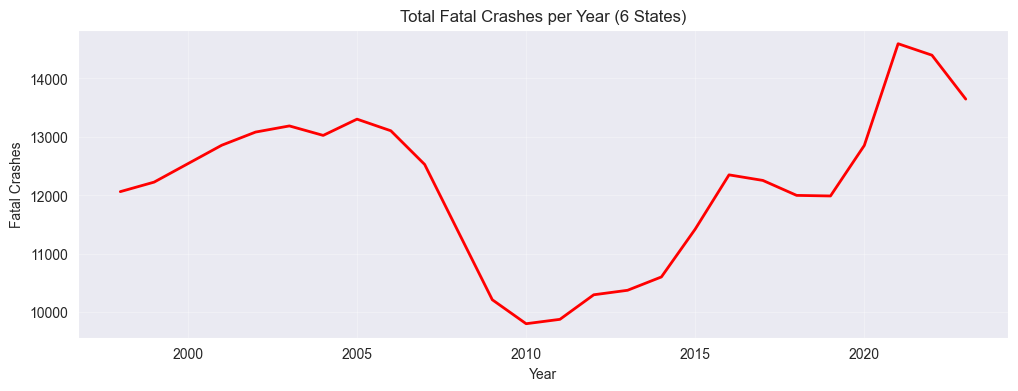

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate total crashes by year
yearly = df_daily.groupby(df_daily['date'].dt.year)['fatal_crashes'].sum()

plt.figure(figsize=(12, 4))
plt.plot(yearly.index, yearly.values, linewidth=2, color='red')
plt.title('Total Fatal Crashes per Year (6 States)')
plt.xlabel('Year')
plt.ylabel('Fatal Crashes')
plt.grid(alpha=0.3)
plt.show()

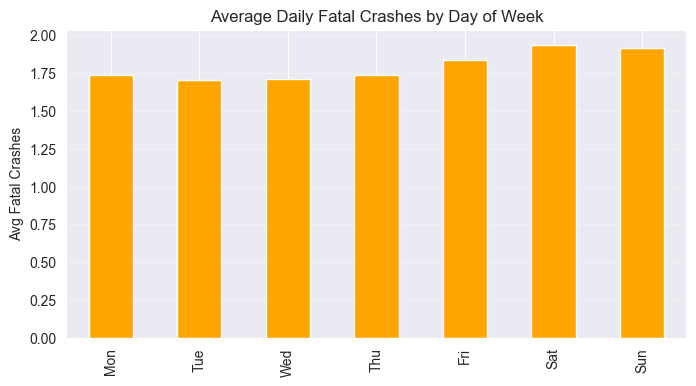

In [41]:
dow = df_daily.groupby('day_of_week')['fatal_crashes'].mean()
dow.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(8, 4))
dow.plot(kind='bar', color='orange')
plt.title('Average Daily Fatal Crashes by Day of Week')
plt.ylabel('Avg Fatal Crashes')
plt.grid(axis='y', alpha=0.3)
plt.show()

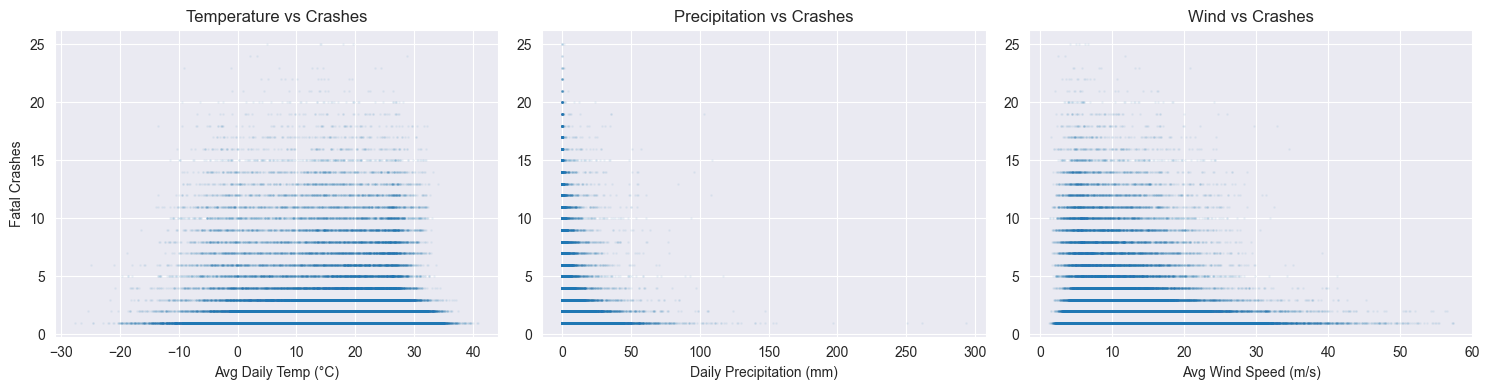

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Temperature
axes[0].scatter(df_daily['temperature_2m_mean'], df_daily['fatal_crashes'], alpha=0.05, s=1)
axes[0].set_xlabel('Avg Daily Temp (°C)')
axes[0].set_ylabel('Fatal Crashes')
axes[0].set_title('Temperature vs Crashes')

# Precipitation
axes[1].scatter(df_daily['precipitation_sum'], df_daily['fatal_crashes'], alpha=0.05, s=1)
axes[1].set_xlabel('Daily Precipitation (mm)')
axes[1].set_title('Precipitation vs Crashes')

# Wind
axes[2].scatter(df_daily['wind_speed_10m_mean'], df_daily['fatal_crashes'], alpha=0.05, s=1)
axes[2].set_xlabel('Avg Wind Speed (m/s)')
axes[2].set_title('Wind vs Crashes')

plt.tight_layout()
plt.show()

In [44]:
### Prepare data for modeling (use 1990+ for better quality)
df_model = df_daily[df_daily['date'].dt.year >= 1990].copy()

# Define features (weather + time)
features = [
    'temperature_2m_mean',
    'precipitation_sum',
    'wind_speed_10m_mean',
    'day_of_week',        # 0=Mon, 6=Sun (treated as numeric for trend)
    'month',              # Seasonality
    'is_weekend',         # Boolean (0/1)
    'is_holiday'          # Boolean (0/1)

]

# Remove any rows with missing weather
df_model = df_model.dropna(subset=features + ['fatal_crashes'])

In [46]:
### Train Poisson model (ideal for count data like crashes)
import statsmodels.api as sm

X = df_model[features]
X = sm.add_constant(X)  # Adds intercept
y = df_model['fatal_crashes']

print("Training Poisson regression model...")
model = sm.GLM(y, X, family=sm.families.Poisson()).fit()

print("\n✅ Model trained!")
print(model.summary().tables[1])  # Coefficients table

Training Poisson regression model...

✅ Model trained!
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.8730      0.007    121.545      0.000       0.859       0.887
temperature_2m_mean    -0.0108      0.000    -54.174      0.000      -0.011      -0.010
precipitation_sum       0.0022      0.000      8.398      0.000       0.002       0.003
wind_speed_10m_mean    -0.0169      0.000    -49.455      0.000      -0.018      -0.016
day_of_week             0.0118      0.002      7.789      0.000       0.009       0.015
month                   0.0040      0.001      7.631      0.000       0.003       0.005
is_weekend              0.0602      0.006      9.403      0.000       0.048       0.073
is_holiday              0.0494      0.014      3.633      0.000       0.023       0.076
